<table>
<tr>    
<td style="text-align: center">
<h1>Transfer Learning and Freezing Layers and Tuning Networks</h1>
<h2><a href="http://home.agh.edu.pl/~horzyk/index.php">Adrian Horzyk</a></h2>
</td>
<td>
<img src="http://home.agh.edu.pl/~horzyk/im/AdrianHorzyk49BT140h.png" alt="Adrian Horzyk, Professor" title="Adrian Horzyk, Professor" />        
</td>
</tr>
</table>
<h3><i>Welcome to the interactive lecture and exercises where you can check everything by yourself and experiment!</i></h3>

# Transfer Learning, i.e. using a pre-trained convnet

----
A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network, which we call <b>transfer learning</b>. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this large dataset is general enough (sufficiently covers input data space), then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world. Moreover, its features can prove useful for many different computer vision problems, even though these problems might involve completely different classes from those of the task for which the original network was trained. For instance, one might train a network on ImageNet and then re-purpose this trained network for identifying, e.g., furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (which includes more than 1.4 million images of 1000 classes that are mostly animals and everyday objects). It contains many classes of animals, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use one of the popular architectures (a simple and widely used convnet VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014) trained on ImageNet. We choose VGG architecture because it is similar to what we are already familiar with - a sequential multi-layer model. It is one of these cutesie model names (VGG, ResNet, Inception, Inception-ResNet, Xception) you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to use a pre-trained network: <b>feature extraction</b> and <b>fine-tuning</b>. We will cover both of them. Let's start with feature extraction.

## Feature extraction and transferring convolutional base

<b>Feature extraction</b> consists of using the representations learned by a network in the past to extract useful and frequent features from new samples. These features are then fed to a new classifier, which is trained from scratch. This new classifier can have different network architecture (a number of layers, a number of neurons in layers, activation functions, and a number of outputs) and be trained to a different computational task.

Convnets used for image classification usually comprise two parts:
* they start with a series of pooling, dopout, and convolutional layers, and
* they end with a densely-connected classifier.

The first part is called the <b>convolutional base</b> of the model. In the case of convnets, <b>feature extraction</b> will simply consist of taking the convolutional base of a previously-trained network.
Next, we run the new data through it and train a new classifier on top of the output of the convolutional base for our new prediction (here classification) tasks:

![swapping fully connected classifier](http://home.agh.edu.pl/~horzyk/lectures/jupyternotebooks/images/TransferredConvolutionalBase.png)

We typically reuse the convolutional base only because the densely-connected classifier was learned the specific and different set of classes representations which would be difficult to use. On the other hand, the convolutional bases are likely to be more generic and therefore more reusable because the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For the problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality and reusability of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the convolutional base to do feature extraction appropriately adapted to your dataset, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it might be beneficial to reuse the information contained in the densely-connected layers of the original model, e.g., adding an additional dense layer on the top of it. However, we will try to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our cat and dog images, and then training a new cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras, so we can import it from the `keras.applications` module. Here's the list of image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model that has a sequential structure, which we already know:

In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!cp ./drive/MyDrive/dogs-vs-cats.zip .

In [ ]:
!ls

dogs-vs-cats.zip  drive  sample_data


In [ ]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!mkdir -p ./data/raw/

In [ ]:
!cp test1.zip train.zip ./data/raw/

In [ ]:
!unzip ./data/raw/train.zip -d ./data/raw/

In [ ]:
!unzip ./data/raw/test1.zip -d ./data/raw/

In [ ]:
!mv ./data/raw/train/*.jpg ./data/raw/

In [ ]:
!mv ./data/raw/test1/*.jpg ./data/raw/

In [ ]:
import os
import shutil

# The path to store trained models
models_dir = './drive/MyDrive/models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = './data/raw/'

# The directory where we will store our smaller dataset
base_dir = './data/processed/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
#from keras.applications import VGG16
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights` to specify which weight checkpoint to initialize the model from;
* `include_top`, which refers to including or not the densely-connected classifier on top of the network;
* `input_shape`, which is the shape of the image tensors that we will feed to the network (if we don't specify it, then the network will be able to process inputs of any size).

Let's look at the imported architecture of the VGG16 convolutional base:

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The VGG16 convolutional base consists of five convolutional blocks with a different number of conv-layers and a different number of filters. The final feature map has shape `(4, 4, 512)`. That's the feature map layer on top of which we will stick a densely-connected classifier.

There are two ways how we could proceed:

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the same reason, this technique would disallow us to use data augmentation, which limits the ability to adapt the model.
* Freeze the (`conv_base`) model and extending it by adding a densely-connected classifier (`Dense`) on top and running the whole model end-to-end on the input data. This allows us to use data augmentation because every input image is going through the convolutional base every time it is seen by the model. However, for the same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our data and using these outputs as inputs to a new classification model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# The directory where we will store our smaller dataset
#base_dir = 'https://home.agh.edu.pl/~horzyk/ml/data/kaggle/processed/cats_and_dogs_small'
base_dir = './data/processed/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, batch_size, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        # put the input data through the conv_base and store the outputs in features
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a for-loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, batch_size, 2000)
validation_features, validation_labels = extract_features(validation_dir, batch_size, 1000)
test_features, test_labels = extract_features(test_dir, batch_size, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 23ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 24ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 23ms/step


The extracted features are currently of shape `(samples, 4, 4, 512)`, so if we want to feed them to a densely-connected classifier, first we must flatten them to `(samples, 4 * 4 * 512)`, which is `(samples, 8192)`:

In [ ]:
#print (train_features.shape)
#print (validation_features.shape)
#print (test_features.shape)
#flatten_layer_size = train_features.shape[1] * train_features.shape[2] * train_features.shape[3]
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))
print (train_features.shape)
print (validation_features.shape)
print (test_features.shape)
flatten_layer_size = train_features.shape[1]  # 4 * 4 * 512

(2000, 8192)
(1000, 8192)
(1000, 8192)


At this point, we can define our densely-connected classifier, and train it on the data and labels that we just recorded:

In [ ]:
import tensorflow
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model3 = models.Sequential()
model3.add(layers.Dense(256, activation='relu', input_dim=flatten_layer_size))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=tensorflow.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history3 = model3.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 6ms/step - loss: 0.7211 - acc: 0.7505 - val_loss: 0.5785 - val_acc: 0.7510
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3681 - acc: 0.8490 - val_loss: 0.3937 - val_acc: 0.8160
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2761 - acc: 0.8890 - val_loss: 0.3177 - val_acc: 0.8640
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2341 - acc: 0.9060 - val_loss: 0.5018 - val_acc: 0.7970
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2127 - acc: 0.9135 - val_loss: 0.5195 - val_acc: 0.8270
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1993 - acc: 0.9250 - val_loss: 0.2787 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1676 - acc: 0.9250 - val_loss: 0.2668 - val_acc: 0.9090
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

In [ ]:
# The path to store trained models
models_dir = './drive/MyDrive/models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

model3.save(models_dir + 'cats_and_dogs_small_3a.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


As we can see, training is very fast, since we only have to deal with two `Dense` layers.

Let's take a look at the loss and accuracy curves during training:

In [ ]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

def PlotAccuracyComparison(acc, val_acc, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25, 5))
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def PlotLossComparison(loss, val_loss, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25, 5))
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

<Figure size 640x480 with 0 Axes>

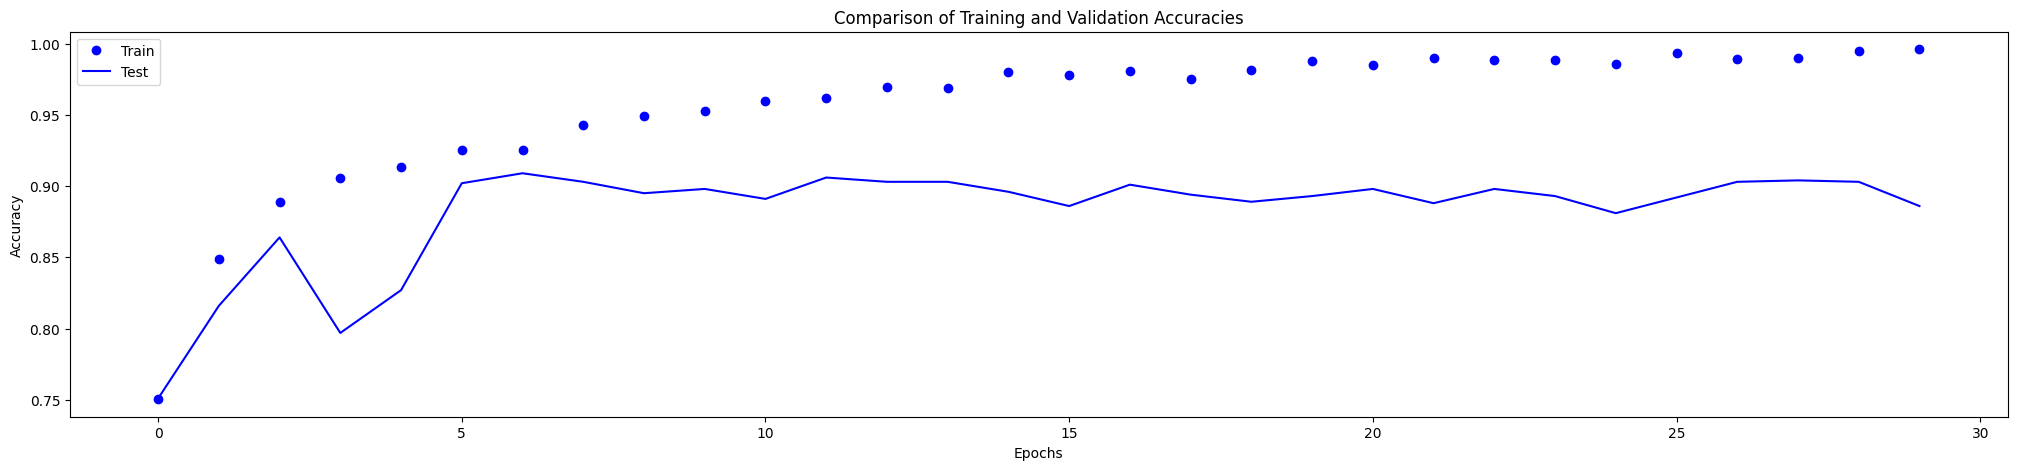

<Figure size 640x480 with 0 Axes>

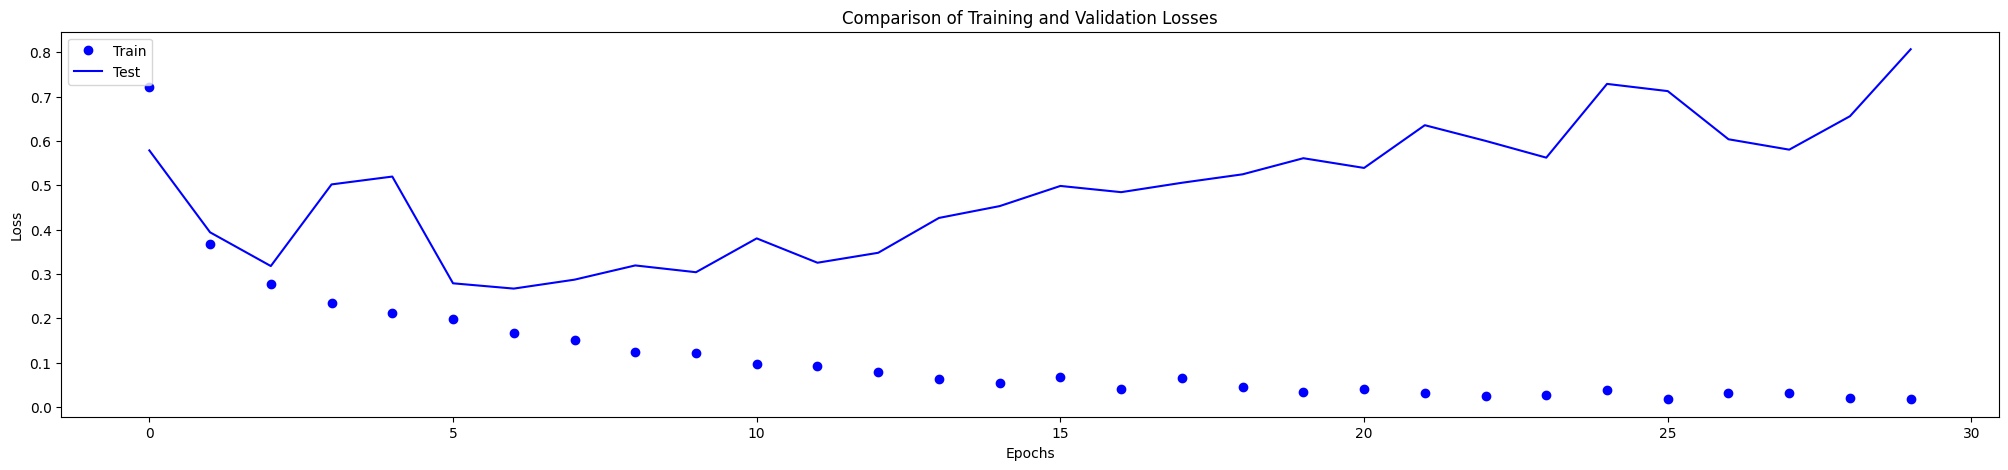

In [ ]:
import matplotlib.pyplot as plt

acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotAccuracyComparison(acc3, val_acc3, lab = 'Model 3')
PlotLossComparison(loss3, val_loss3, lab = 'Model 3')

After 30 epochs, we reach a validation accuracy of about 90% - that is much better than what we could achieve in the previous model trained from scratch on our small dataset. However, our plots also indicate that we are overfitting almost from the start, despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's use the second technique for doing feature extraction, which is much slower and more expensive but allows us to leverage data augmentation during training by extending the `conv_base` model and running it end-to-end on the inputs. Note that this technique is in fact, so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU! If you cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. So you can do the following:

In [ ]:
from keras import models
from keras import layers

model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters! The classifier we are adding on top has only about 2,097,408 parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized (trained nothing at the beginning), very large weight updates would be propagated through the network, effectively destroying the representations previously learned and transferred to this model.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [ ]:
print('This is the number of trainable weights before freezing the conv base:', len(model3.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


Now, we freeze the `conv_base` and look again at the number of trainable weights:

In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights after freezing the conv base:', len(model3.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


After freezing the `conv_base`, only the weights and biases from the two `Dense` layers will be trained. We get here a total number of used tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes (freezing) to take effect, we must compile the model. If you ever modify weight trainability after compilation, we should compile the model, or these changes would be ignored.

Now we can start training our model with the same data augmentation configuration that we used in our previous example:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model3.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=2e-5),
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

# https://keras.io/api/models/model_training_apis/
#history = model3.fit_generator(
history = model3.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 14s - loss: 0.6056 - acc: 0.6815 - val_loss: 0.4681 - val_acc: 0.8160 - 14s/epoch - 142ms/step
Epoch 2/30
100/100 - 13s - loss: 0.5036 - acc: 0.7700 - val_loss: 0.3967 - val_acc: 0.8390 - 13s/epoch - 134ms/step
Epoch 3/30
100/100 - 13s - loss: 0.4508 - acc: 0.7995 - val_loss: 0.3527 - val_acc: 0.8540 - 13s/epoch - 131ms/step
Epoch 4/30
100/100 - 13s - loss: 0.4256 - acc: 0.8050 - val_loss: 0.3450 - val_acc: 0.8540 - 13s/epoch - 132ms/step
Epoch 5/30
100/100 - 13s - loss: 0.4119 - acc: 0.8195 - val_loss: 0.3090 - val_acc: 0.8750 - 13s/epoch - 132ms/step
Epoch 6/30
100/100 - 13s - loss: 0.3888 - acc: 0.8255 - val_loss: 0.3052 - val_acc: 0.8750 - 13s/epoch - 133ms/step
Epoch 7/30
100/100 - 13s - loss: 0.3703 - acc: 0.8330 - val_loss: 0.2932 - val_acc: 0.8850 - 13s/epoch - 131ms/step
Epoch 8/30
100/100 - 13s - loss: 0.3645 - acc: 0.8260 - val_loss: 0.2817 - val_acc: 0.8800 - 13s/epoch -

In [ ]:
model3.save(models_dir + 'cats_and_dogs_small_3.h5')

Let's plot our results again:

<Figure size 640x480 with 0 Axes>

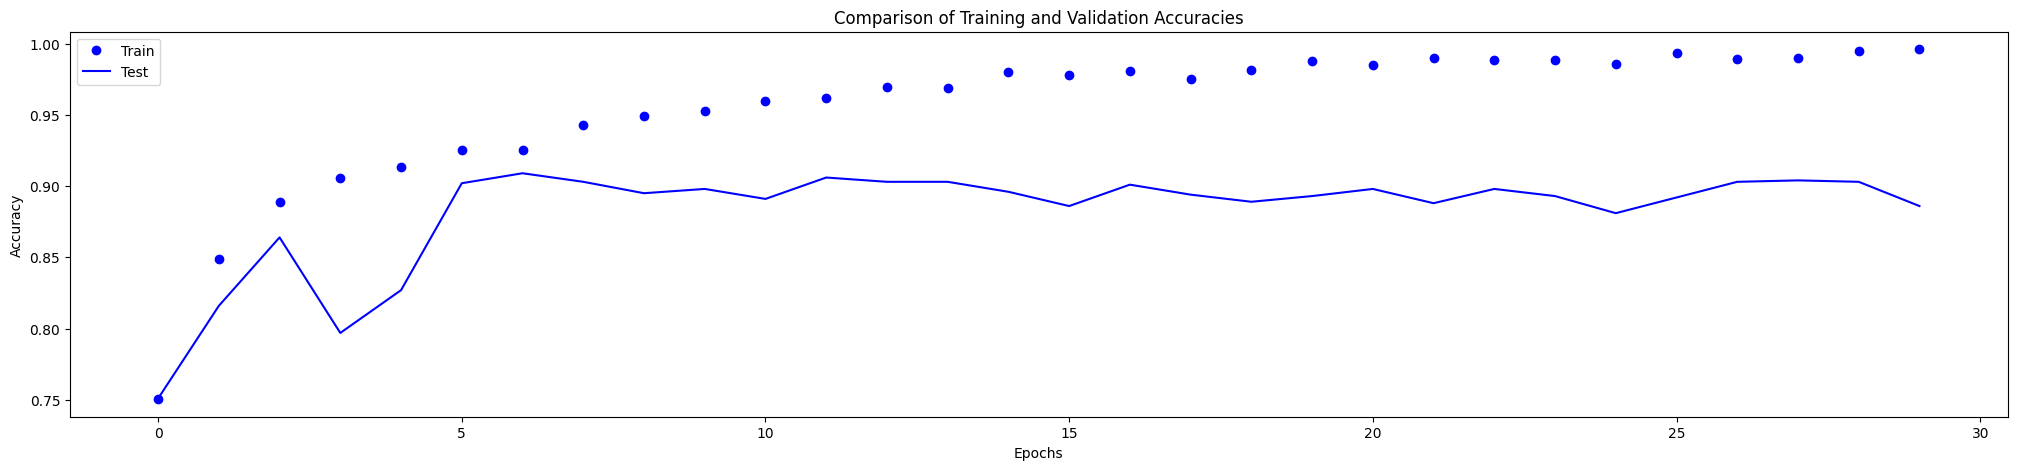

<Figure size 640x480 with 0 Axes>

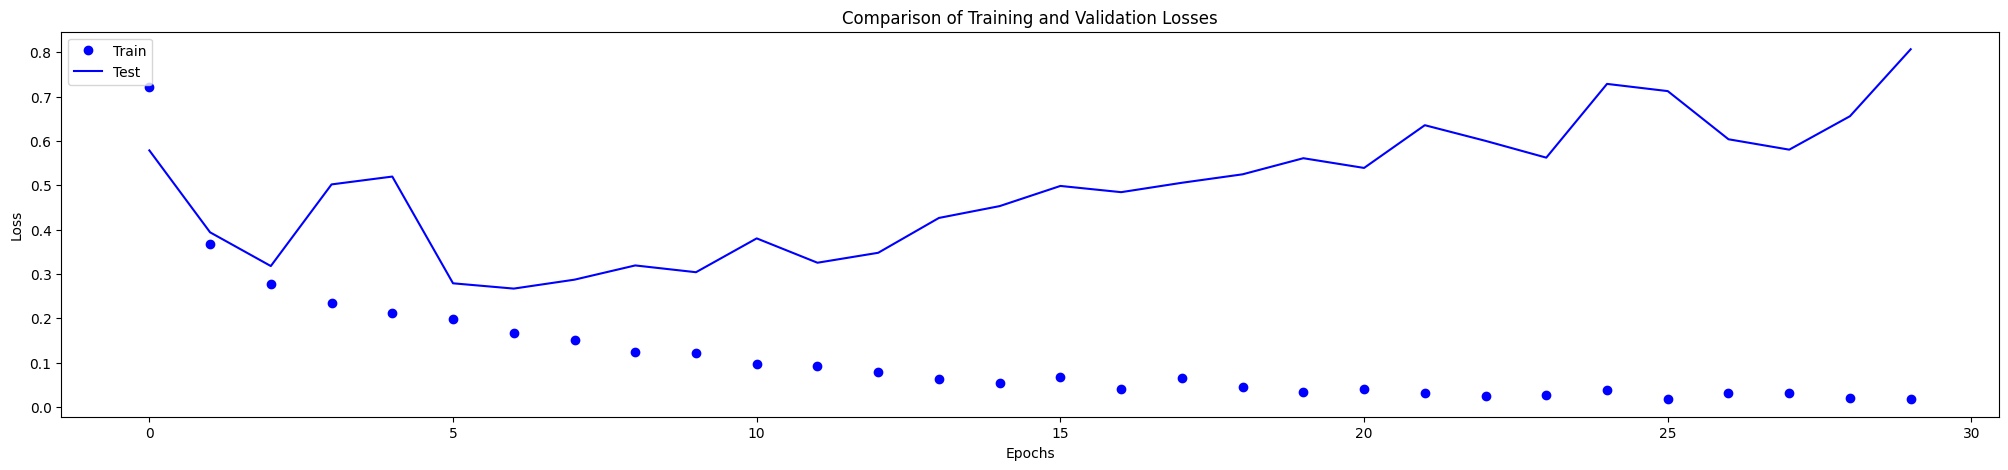

In [ ]:
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotAccuracyComparison(acc3, val_acc3, lab = 'Model 3')
PlotLossComparison(loss3, val_loss3, lab = 'Model 3')

As you can see, we reach a validation accuracy of about 94%. This is much better than our small convnet (model2) trained from scratch.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is <b>fine-tuning</b>.
Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers, representing high-order features. This is called <b>fine-tuning</b> because it slightly adjusts the more abstract representations of the model being reused in order to make them more relevant for the problem at hand.

![VGG-16 network with 4 frozen blocks and 1 fine-tuned block and classifier](http://home.agh.edu.pl/~horzyk/lectures/jupyternotebooks/images/VGG16-partially-frozen.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus, the steps for fine-tuning a network are as follow:

<ol>
    <li>Add your custom network on top of an already trained network base.</li>
    <li>Freeze the base network.</li>
    <li>Train the part (e.g. classifier) you added.</li>
    <li>Unfreeze the last layers in the network base.</li>
    <li>Jointly train both these unfrozen layers and the part you added.</li>
    <li>While the results are not yet satisfactory and represented features in the last layers do not suit to our problem</li>
    <ol>
        <li>Unfreeze a few additional last layers in the network base.</li>
        <li>Jointly train both these unfrozen layers and the part you added.</li>
    </ol>
</ol>
   
We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step now: we will unfreeze our `conv_base`, and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2` and `block5_conv3` should become trainable (unfrozen) again.

We could fine-tune more layers or even the entire convolutional base. However, we should consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. In our case, the convolutional base has over 14M parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up and unfreeze three layers of the 5th convolutional block:

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate because we want to limit the magnitude of the modifications we make to the representations of the 3 layers of the 5th convolutional block that we are fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

#history4 = model3.fit_generator(
history4 = model3.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 15s 134ms/step - loss: 17.8858 - acc: 0.5130 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 13s 134ms/step - loss: 0.6933 - acc: 0.4985 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/100
100/100 [==============================] - 13s 134ms/step - loss: 0.6932 - acc: 0.4830 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/100
100/100 [==============================] - 13s 133ms/step - loss: 0.6932 - acc: 0.4850 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/100
100/100 [==============================] - 13s 133ms/step - loss: 0.6932 - acc: 0.4900 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/100
100/100 [==============================] - 13s 134ms/step - loss: 0.6932 - acc: 0.4830 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/100
100/100 [==============================] - 14s 135ms/step - loss: 0.6932 - acc: 0.4940 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/100
100/100 [==========================

In [ ]:
model3.save(models_dir + 'cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

<Figure size 640x480 with 0 Axes>

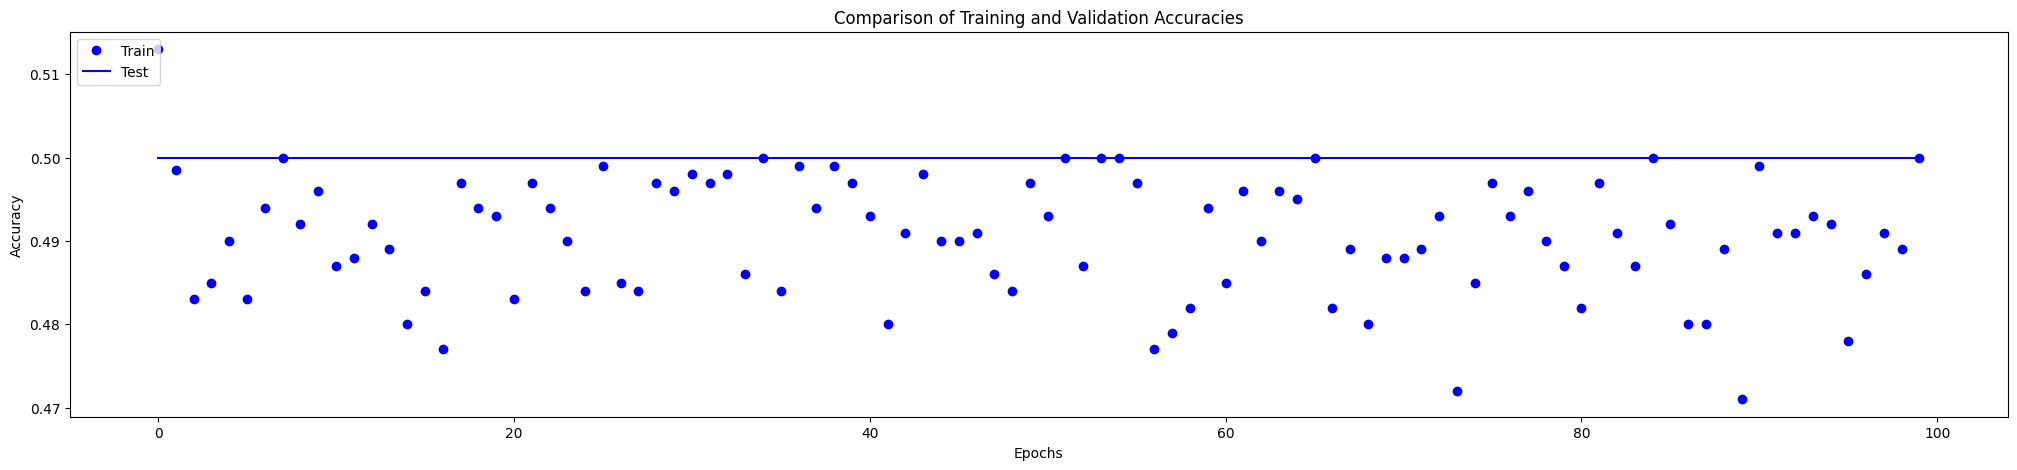

<Figure size 640x480 with 0 Axes>

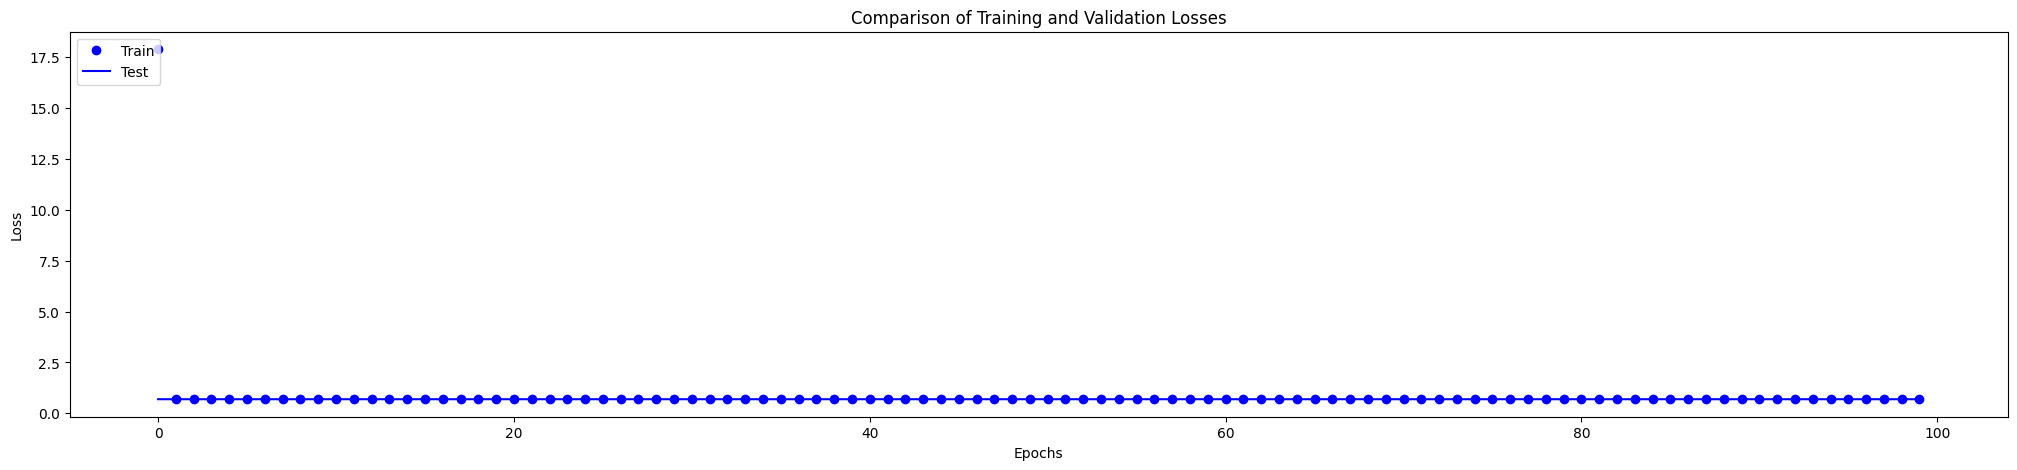

In [ ]:
import matplotlib.pyplot as plt

acc4 = history4.history['acc']
val_acc4 = history4.history['val_acc']
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

PlotAccuracyComparison(acc4, val_acc4, lab = 'Model 4 - fined tuned the 5th conv-block')
PlotLossComparison(loss4, val_loss4, lab = 'Model 4 - fined tuned the 5th conv-block')


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving
averages of these quantities. Here's a trivial utility function to do this:

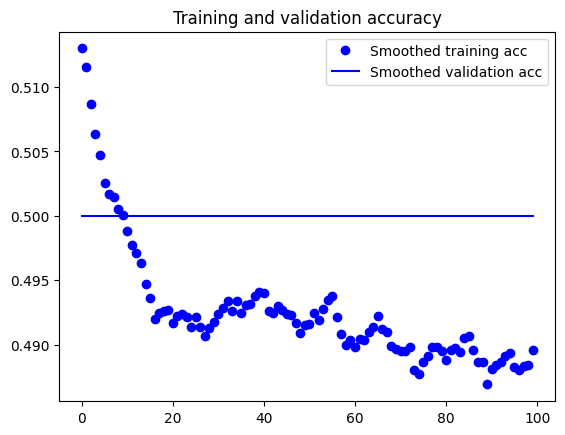

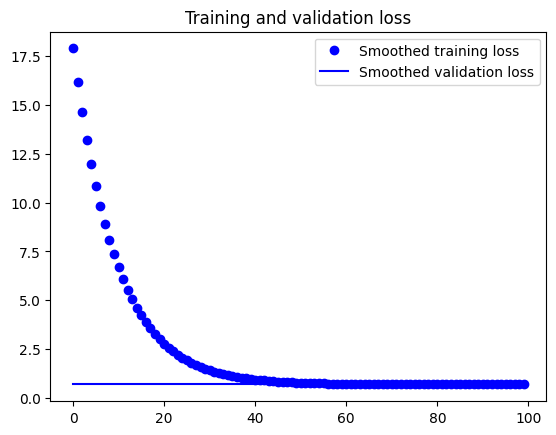

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

epochs = range(len(acc4))

plt.plot(epochs, smooth_curve(acc4), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc4), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss4), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss4), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look much cleaner and more stable. We can easier see a ~1% absolute improvement of the validation accuracy at the end of the training process.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the loss isn't decreasing? The answer is that we display an average of pointwise loss values, but what actually matters for accuracy is the distribution of the loss values, not their average, since accuracy is the result of binary thresholding of the class probability predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

#test_loss4, test_acc4 = model3.evaluate_generator(test_generator, steps=50)
test_loss4, test_acc4 = model3.evaluate(test_generator, steps=50)
print('test acc:', test_acc4)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 31ms/step - loss: 0.6931 - acc: 0.5000
test acc: 0.5


Here we get a test accuracy of ~93.8
%. In the original Kaggle competition around this dataset, this would have been one of the top results because the best results were ~95%. However, using modern deep learning techniques, we managed to reach this result using only a very small (8%) fraction of the training data available. There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples and train on 2,000 samples compared to 1,000 samples!  

## Take-aways: using convnets with small datasets

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.
* It is easy to reuse an existing convnet on a new dataset via feature extraction (transfer learning). This is a very valuable technique for working with small image datasets that can substantially improve results.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model (using unfrozen layers). This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.

## Assignments

* Try to unfreeze more conv-layers (e.g. from the 4th block) and train the previously trained model to increase the accuracy of the model on the test data. Then, compare the results and conclude about the improvement of the model.
* Try to use everything we learned until now, changing hyperparameters individually after the experience you gained during your previous experiments and after the tips and tricks, you learned during the lectures.
* If you have enough powerful GPU unit, you can try to increase the number of training data (from 2,000 to a few thousands more, e.g.: 5,000, 10,000, or 20,000) and compare the results with ours achieved here.
* Optionally, you can check the other types of conv-bases like VGG19, Xception, InceptionV3, or ResNet50.